In [ ]:
import warnings

import numpy as np
from numpy import array
import pandas as pd
from pandas import concat
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import ParameterGrid

pd.plotting.register_matplotlib_converters()

warnings.filterwarnings("ignore")

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data =  pd.read_csv("salesmonthly.csv")
data.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,2014-01-31,127.69,99.090,152.100,878.030,354.0,50.0,112.0,48.2
1,2014-02-28,133.32,126.050,177.000,1001.900,347.0,31.0,122.0,36.2
2,2014-03-31,137.44,92.950,147.655,779.275,232.0,20.0,112.0,85.4
3,2014-04-30,113.10,89.475,130.900,698.500,209.0,18.0,97.0,73.7
4,2014-05-31,101.79,119.933,132.100,628.780,270.0,23.0,107.0,123.7


In [ ]:
import datetime as dt
data1 = data
data1['datum'] = pd.to_datetime(data1['datum'], format= '%Y-%m-%d')
data1['year'] = data1['datum'].dt.year
data1['month'] = data1['datum'].dt.month
data1['day'] = data1['datum'].dt.day

In [ ]:
data = data1
data

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,year,month,day
0,2014-01-31,127.69,99.090,152.100,878.030,354.0,50.0,112.0,48.20,2014,1,31
1,2014-02-28,133.32,126.050,177.000,1001.900,347.0,31.0,122.0,36.20,2014,2,28
2,2014-03-31,137.44,92.950,147.655,779.275,232.0,20.0,112.0,85.40,2014,3,31
3,2014-04-30,113.10,89.475,130.900,698.500,209.0,18.0,97.0,73.70,2014,4,30
4,2014-05-31,101.79,119.933,132.100,628.780,270.0,23.0,107.0,123.70,2014,5,31
...,...,...,...,...,...,...,...,...,...,...,...,...
65,2019-06-30,151.54,101.627,103.200,610.000,193.0,25.0,142.0,156.04,2019,6,30
66,2019-07-31,181.00,103.541,92.800,649.800,250.6,20.0,115.0,105.20,2019,7,31
67,2019-08-31,181.91,88.269,84.200,518.100,237.0,26.0,145.0,97.30,2019,8,31
68,2019-09-30,161.07,111.437,93.500,984.480,227.8,16.0,161.0,109.10,2019,9,30


# Seasonality analysis

The seasonality patterns can be explored in detail by using boxplots. Seasonality is clearly confirmed for the categories of R03, R06 and N02BE. Some additional conclusions: R03 and N05C has more outliers that the others, indicating that their sales is more difficult to predict.

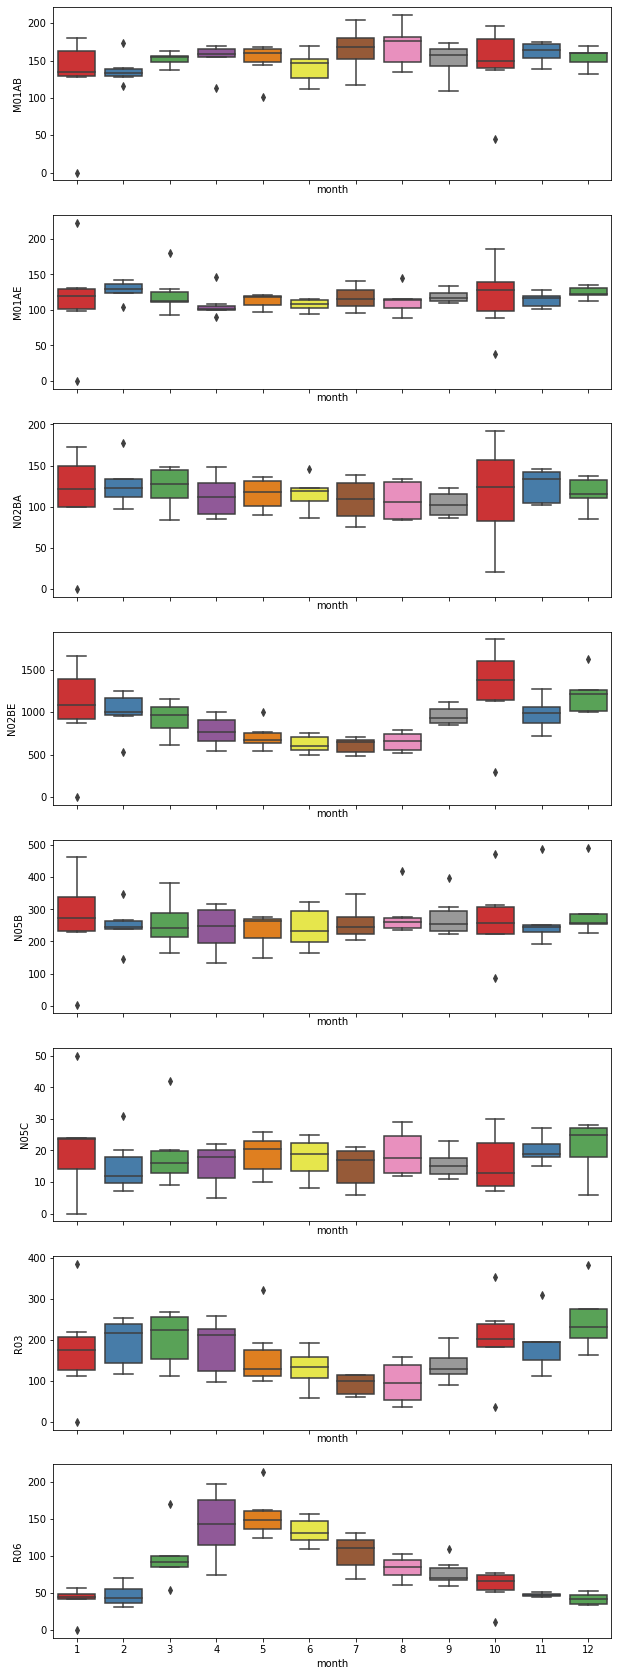

In [ ]:
import seaborn as sns
dfatc_daily = data
fig, axes = plt.subplots(8, 1, figsize=(10, 30), sharex=True)
for name, ax in zip(['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06'], axes):
    sns.boxplot(data=dfatc_daily, x='month',palette='Set1' ,y=name, ax=ax)
    

Another visualization that can be useful for discovering seasonality patterns is related to rolling window means. Rolling window operations are another important transformation for time series data.

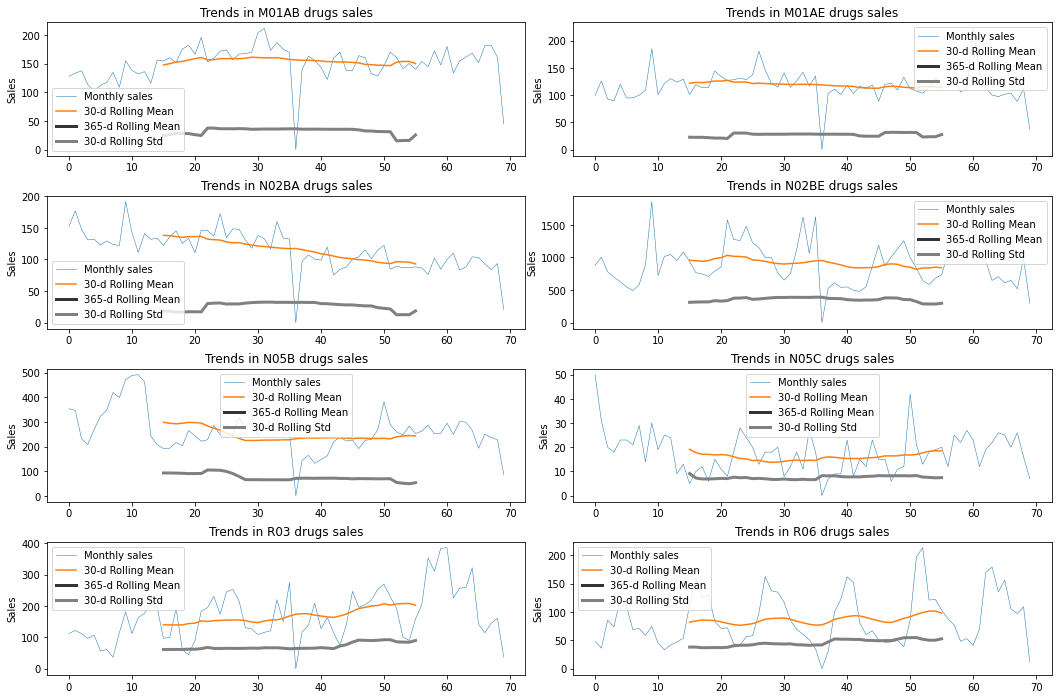

In [ ]:
dfatc_daily=data
cols_plot = ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']
dfatc_365d = dfatc_daily[cols_plot].rolling(window=365, center=True).mean()
dfatc_30d = dfatc_daily[cols_plot].rolling(30, center=True).mean()
dfatc_std = dfatc_daily[cols_plot].rolling(30, center=True).std()
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18, 12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

for x in cols_plot:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    ax[rowindex,colindex].plot(dfatc_daily.loc[:,x], linewidth=0.5, label='Monthly sales')
    ax[rowindex,colindex].plot(dfatc_30d.loc[:,x], label='30-d Rolling Mean')
    ax[rowindex,colindex].plot(dfatc_365d.loc[:,x], color='0.2', linewidth=3, label='365-d Rolling Mean')
    ax[rowindex,colindex].plot(dfatc_std.loc[:,x], color='0.5', linewidth=3, label='30-d Rolling Std')
    ax[rowindex,colindex].set_ylabel('Sales')
    ax[rowindex,colindex].legend()
    ax[rowindex,colindex].set_title('Trends in '+x+' drugs sales');   
    subplotindex=subplotindex+1
plt.show()

Image below shows trends for each of the drug categories, represented by the 365-d rolling means for each of those categories.

Function seasonal_decompose can be used for analysis of the portions of each component of time series. This is especially useful when determining uptake of residuals in data, based on the decomposed data. 

In [10]:
df = data
for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    result = seasonal_decompose(df[x], freq=52, model='additive')
    dfs = pd.concat([result.trend, result.seasonal, result.resid, result.observed], axis=1)
    dfs.columns = ['trend', 'seasonal', 'residuals', 'observed']
    dfs=dfs.dropna()
    res=dfs['residuals'].values
    obs=dfs['observed'].values
    resmean=np.mean(np.abs(res))
    obsmean=np.mean(np.abs(obs))
    perc=resmean*100/obsmean
    print(x+' RESMEAN:'+str(resmean)+', OBSMEAN:'+str(obsmean)+', PERC:'+str(perc)+'%')

M01AB RESMEAN:nan, OBSMEAN:nan, PERC:nan%
M01AE RESMEAN:nan, OBSMEAN:nan, PERC:nan%
N02BA RESMEAN:nan, OBSMEAN:nan, PERC:nan%
N02BE RESMEAN:nan, OBSMEAN:nan, PERC:nan%
N05B RESMEAN:nan, OBSMEAN:nan, PERC:nan%
N05C RESMEAN:nan, OBSMEAN:nan, PERC:nan%
R03 RESMEAN:nan, OBSMEAN:nan, PERC:nan%
R06 RESMEAN:nan, OBSMEAN:nan, PERC:nan%


# Stationarity analysis

Stationarity of time-series is the property of exhibiting constant statistical properties over time (for example, mean, variance, autocorrelation). It can be visually determined by plotting rolling statistics (rolling means and variances). In stationary time series, the mean of the series, variance of the series and covariance of the i th term and the (i + m) th term should not be a function of time.

In [ ]:
df= data
from statsmodels.tsa.stattools import adfuller

for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
    dftest = adfuller(df[x], regression='ct', autolag='AIC')
    print("ADF test for "+x)
    print("-----------------------------")
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

ADF test for M01AB
-----------------------------
Test statistic = -5.276
P-value = 0.000
Critical values :
	1%: -4.096353737736257 - The data is  stationary with 99% confidence
	5%: -3.476155027137765 - The data is  stationary with 95% confidence
	10%: -3.165414996392793 - The data is  stationary with 90% confidence
ADF test for M01AE
-----------------------------
Test statistic = -6.592
P-value = 0.000
Critical values :
	1%: -4.096353737736257 - The data is  stationary with 99% confidence
	5%: -3.476155027137765 - The data is  stationary with 95% confidence
	10%: -3.165414996392793 - The data is  stationary with 90% confidence
ADF test for N02BA
-----------------------------
Test statistic = -6.666
P-value = 0.000
Critical values :
	1%: -4.096353737736257 - The data is  stationary with 99% confidence
	5%: -3.476155027137765 - The data is  stationary with 95% confidence
	10%: -3.165414996392793 - The data is  stationary with 90% confidence
ADF test for N02BE
---------------------------

Augmented Dickey-Fuller (ADF) test have shown that all data, but N02BA (P-value=0.249) in the series were stationary, with maximum confidence.

In [ ]:
from statsmodels.tsa.stattools import kpss
warnings.filterwarnings("ignore")
df=data
for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
    print(" > Is "+x+" data stationary ?")
    dftest = kpss(np.log(df[x]), 'ct')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[3].items():
        print("\t{}: {}".format(k, v))

 > Is M01AB data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is M01AE data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N02BA data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N02BE data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N05B data stationary ?
Test statistic = 0.107
P-value = 0.100
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N05C data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is R03 data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is R06 data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.1

# Regularity analysis

For calculating regularity and predictability of time series, Approximate Entropy test was used.

In [ ]:
df = data    
def ApEn(U, m, r):
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))
    N = len(U)
    return abs(_phi(m+1) - _phi(m))

for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    print(x + ': ' + str(ApEn(df[x].values, m=2, r=0.2*np.std(df[x].values))))

M01AB: 0.5893983583885993
M01AE: 0.7448566398818222
N02BA: 0.6121630386995687
N02BE: 0.5743235328896188
N05B: 0.6849623624662486
N05C: 0.382530748050697
R03: 0.44041794673092216
R06: 0.4869970603922926


# Autocorrelation analysis

Autocorrelation analysis illustrates the potential for time series data prediction. Autocorrelation plots graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps. Pearson coefficient is used to measure autocorrelation. Thus, the following analysis is relevant only for data with normal Gaussian distribution.

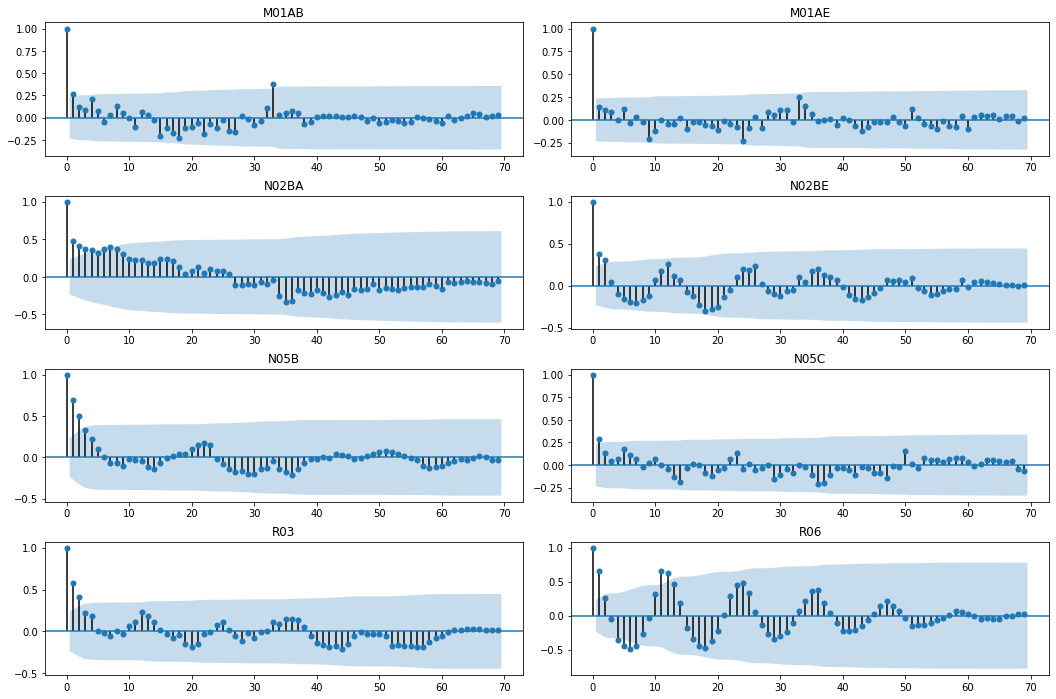

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
df = data
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
with plt.rc_context():
    plt.rc("figure", figsize=(18,12))
    for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
        rowindex=math.floor(subplotindex/numcols)
        colindex=subplotindex-(rowindex*numcols)
        plot_acf(df[x], lags=69, title=x, ax=ax[rowindex,colindex])
        subplotindex=subplotindex+1

In general, the "partial" correlation between two variables is the amount of correlation between them which is not explained by their mutual correlations with a specified set of other variables.

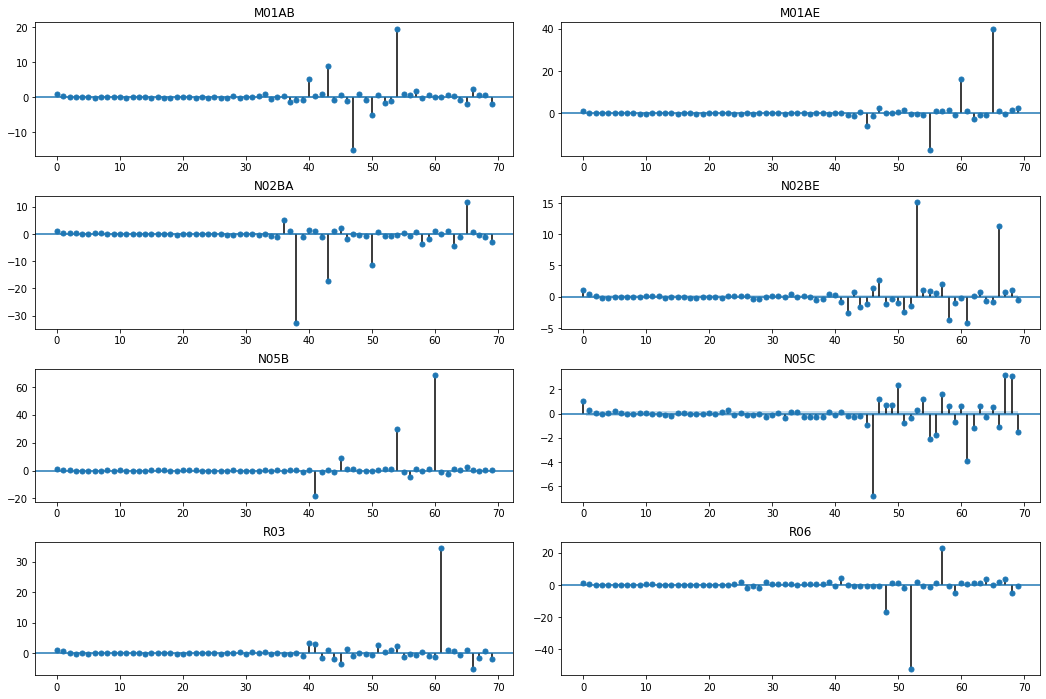

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
df = data
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
with plt.rc_context():
    plt.rc("figure", figsize=(14,6))
    for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
        rowindex=math.floor(subplotindex/numcols)
        colindex=subplotindex-(rowindex*numcols)
        plot_pacf(df[x], lags=77, title=x, ax=ax[rowindex,colindex])
        subplotindex=subplotindex+1

# Data distribution analysis

Chart with daily sales for different categories of interest is shown below.

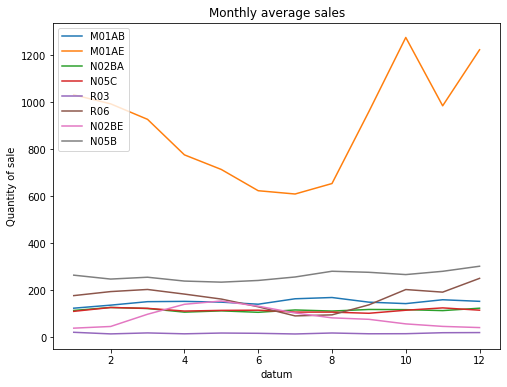

In [ ]:
dfatch= data
dfatch['datum']= pd.to_datetime(dfatch['datum']) 

grp1=dfatch.groupby(dfatch.datum.dt.month)['M01AB'].mean()
grp2=dfatch.groupby(dfatch.datum.dt.month)['M01AE'].mean()
grp3=dfatch.groupby(dfatch.datum.dt.month)['N02BA'].mean()
grp6=dfatch.groupby(dfatch.datum.dt.month)['N05C'].mean()
grp7=dfatch.groupby(dfatch.datum.dt.month)['R03'].mean()
grp8=dfatch.groupby(dfatch.datum.dt.month)['R06'].mean()
grp4=dfatch.groupby(dfatch.datum.dt.month)['N02BE'].mean()
grp5=dfatch.groupby(dfatch.datum.dt.month)['N05B'].mean()

plt.title('Monthly average sales')
plt.xlabel('Time of day')
plt.ylabel('Quantity of sale')

grp1.plot(figsize=(8,6))
grp4.plot(figsize=(8,6))
grp2.plot(figsize=(8,6))
grp3.plot(figsize=(8,6))
grp6.plot(figsize=(8,6))
grp7.plot(figsize=(8,6))
grp8.plot(figsize=(8,6))
grp5.plot(figsize=(8,6))

plt.legend(['M01AB', 'M01AE', 'N02BA', 'N05C', 'R03', 'R06', "N02BE", "N05B"], loc='upper left')

plt.show()

# Import the Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import the Dataset

In [ ]:
data =  pd.read_csv("salesmonthly.csv")
data.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,2014-01-31,127.69,99.090,152.100,878.030,354.0,50.0,112.0,48.2
1,2014-02-28,133.32,126.050,177.000,1001.900,347.0,31.0,122.0,36.2
2,2014-03-31,137.44,92.950,147.655,779.275,232.0,20.0,112.0,85.4
3,2014-04-30,113.10,89.475,130.900,698.500,209.0,18.0,97.0,73.7
4,2014-05-31,101.79,119.933,132.100,628.780,270.0,23.0,107.0,123.7


# Data Preparation

## Pre-Processing

### Categorical Data

In [ ]:
data.dtypes

datum     object
M01AB    float64
M01AE    float64
N02BA    float64
N02BE    float64
N05B     float64
N05C     float64
R03      float64
R06      float64
dtype: object

In [ ]:
data1 = data

### Missing Values

In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   datum   70 non-null     object 
 1   M01AB   70 non-null     float64
 2   M01AE   70 non-null     float64
 3   N02BA   70 non-null     float64
 4   N02BE   70 non-null     float64
 5   N05B    70 non-null     float64
 6   N05C    70 non-null     float64
 7   R03     70 non-null     float64
 8   R06     70 non-null     float64
dtypes: float64(8), object(1)
memory usage: 5.0+ KB


In [ ]:
data1.isna().sum()

datum    0
M01AB    0
M01AE    0
N02BA    0
N02BE    0
N05B     0
N05C     0
R03      0
R06      0
dtype: int64

### Outlier Data

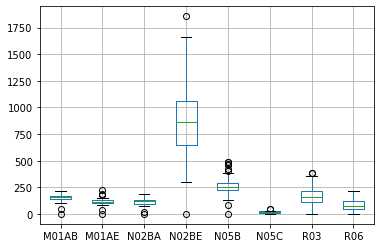

In [ ]:
data1.boxplot()

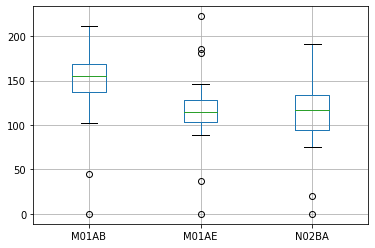

In [ ]:
data1.iloc[:,[1,2,3]].boxplot()

chon outlier ha ro dar dataset haye qabl negah dashtim pas, tasmim be negahdari az onha gerfte shod bejaye hazf anha.

### Duplicated Data

In [ ]:
data1.duplicated().sum()

0

### Date time

In [ ]:
data1['datum'] = pd.to_datetime(data1['datum'], format= '%Y-%m-%d')

In [ ]:
data1.dtypes

datum    datetime64[ns]
M01AB           float64
M01AE           float64
N02BA           float64
N02BE           float64
N05B            float64
N05C            float64
R03             float64
R06             float64
dtype: object

In [ ]:
import datetime as dt
data1['year'] = data1['datum'].dt.year
data1['month'] = data1['datum'].dt.month
data1['day'] = data1['datum'].dt.day


In [ ]:
#data1.set_index(data1['datum'], inplace= True)

In [ ]:
data1.dtypes

datum    datetime64[ns]
M01AB           float64
M01AE           float64
N02BA           float64
N02BE           float64
N05B            float64
N05C            float64
R03             float64
R06             float64
year              int64
month             int64
day               int64
dtype: object

In [ ]:
data1

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,year,month,day
0,2014-01-31,127.69,99.090,152.100,878.030,354.0,50.0,112.0,48.20,2014,1,31
1,2014-02-28,133.32,126.050,177.000,1001.900,347.0,31.0,122.0,36.20,2014,2,28
2,2014-03-31,137.44,92.950,147.655,779.275,232.0,20.0,112.0,85.40,2014,3,31
3,2014-04-30,113.10,89.475,130.900,698.500,209.0,18.0,97.0,73.70,2014,4,30
4,2014-05-31,101.79,119.933,132.100,628.780,270.0,23.0,107.0,123.70,2014,5,31
...,...,...,...,...,...,...,...,...,...,...,...,...
65,2019-06-30,151.54,101.627,103.200,610.000,193.0,25.0,142.0,156.04,2019,6,30
66,2019-07-31,181.00,103.541,92.800,649.800,250.6,20.0,115.0,105.20,2019,7,31
67,2019-08-31,181.91,88.269,84.200,518.100,237.0,26.0,145.0,97.30,2019,8,31
68,2019-09-30,161.07,111.437,93.500,984.480,227.8,16.0,161.0,109.10,2019,9,30


In [ ]:
import matplotlib.dates as mdates

data1['Date'] = data1['datum'].map(mdates.date2num)

In [ ]:
data1

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,year,month,day,Date
0,2014-01-31,127.69,99.090,152.100,878.030,354.0,50.0,112.0,48.20,2014,1,31,735264.0
1,2014-02-28,133.32,126.050,177.000,1001.900,347.0,31.0,122.0,36.20,2014,2,28,735292.0
2,2014-03-31,137.44,92.950,147.655,779.275,232.0,20.0,112.0,85.40,2014,3,31,735323.0
3,2014-04-30,113.10,89.475,130.900,698.500,209.0,18.0,97.0,73.70,2014,4,30,735353.0
4,2014-05-31,101.79,119.933,132.100,628.780,270.0,23.0,107.0,123.70,2014,5,31,735384.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2019-06-30,151.54,101.627,103.200,610.000,193.0,25.0,142.0,156.04,2019,6,30,737240.0
66,2019-07-31,181.00,103.541,92.800,649.800,250.6,20.0,115.0,105.20,2019,7,31,737271.0
67,2019-08-31,181.91,88.269,84.200,518.100,237.0,26.0,145.0,97.30,2019,8,31,737302.0
68,2019-09-30,161.07,111.437,93.500,984.480,227.8,16.0,161.0,109.10,2019,9,30,737332.0


In [ ]:
Data= data1.iloc[:,8:9]
Data

,R06
0,48.20
1,36.20
2,85.40
3,73.70
4,123.70
...,...
65,156.04
66,105.20
67,97.30
68,109.10


# **XG boost**

In [ ]:
#import the libraries
import math
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error , mean_absolute_percentage_error


In [ ]:
features = list(data1.columns)
del features[0]
del features[8:]
features

['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']

In [ ]:
mse = []
rmse = []
mape = []
mbe = []
mae = []

[16:46:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

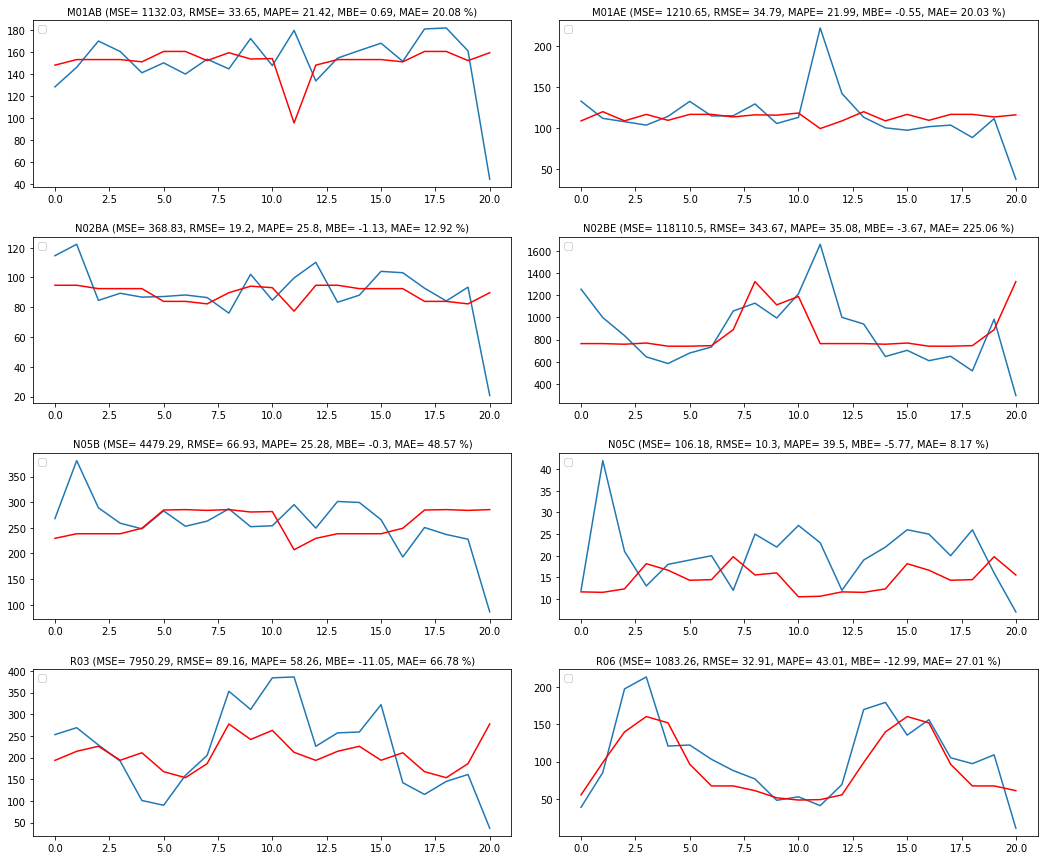

In [ ]:
subplotindex=0
fig, ax = plt.subplots(4, 2, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
warnings.filterwarnings("ignore")

for j in features:
  dataset = data1.filter([j,"year","month","day"])
  training_data = math.ceil(len(dataset) * 0.7)

  # #create the training data set
  # train_data = sc_data[0:training_data , :]

  #split
  X_train = dataset.iloc[0:training_data,1:]
  y_train = dataset.iloc[0:training_data,0]
  X_test = dataset.iloc[training_data:,1:]
  y_test = dataset.iloc[training_data:,0]
  
  reg = XGBRegressor(n_estimators=1000)
  reg.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=50, verbose=False)

  #get the models predicted price values
  predictions = reg.predict(X_test)
  
  # Validation
  # Mean Squarred Error (MSE) 
  MSE = np.round(mean_squared_error(y_test, predictions),2)
  mse.append(MSE)
  # Root Mean Squarred Error (RMSE) 
  RMSE = np.round(np.sqrt(MSE),2)
  rmse.append(RMSE)
  # Mean Absolute Percentage Error (MAPE)
  MAPE = np.round(mean_absolute_percentage_error(y_test, predictions)*100,2)
  mape.append(MAPE)
  # Mean Bias Error (MBE)
  MBE = np.round(np.mean(predictions-y_test),2)
  mbe.append(MBE)
  # Mean Absolute Error (MAE)
  MAE = np.round(mean_absolute_error(y_test, predictions),2)
  mae.append(MAE)

  #plot the data
  rowindex = math.floor(subplotindex/2)
  colindex = subplotindex-(rowindex*2)
  ax[rowindex,colindex].set_title("{0} (MSE= {1}, RMSE= {2}, MAPE= {3}, MBE= {4}, MAE= {5} %)".format(j ,MSE ,RMSE ,MAPE, MBE, MAE), fontsize = 10)
  ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
  ax[rowindex,colindex].plot(y_test.values)
  ax[rowindex,colindex].plot(predictions, color='red')
  subplotindex=subplotindex+1
plt.show()

In [ ]:
  X_train = dataset.iloc[0:training_data,1:]
  y_train = dataset.iloc[0:training_data,0]
  X_test = dataset.iloc[training_data:,1:]
  y_test = dataset.iloc[training_data:,0]

In [ ]:
X_test

,year,month,day
49,2018,2,28
50,2018,3,31
51,2018,4,30
52,2018,5,31
53,2018,6,30
54,2018,7,31
55,2018,8,31
56,2018,9,30
57,2018,10,31
58,2018,11,30


In [ ]:
predictions

array([ 55.66952 ,  98.818146, 139.68732 , 160.19098 , 151.76717 ,
        96.544716,  67.585106,  67.59405 ,  61.27827 ,  51.721573,
        48.766857,  49.31668 ,  55.66952 ,  98.818146, 139.68732 ,
       160.19098 , 151.76717 ,  96.544716,  67.585106,  67.59405 ,
        61.27827 ], dtype=float32)

In [ ]:
y_test.values

array([ 39.06,  85.5 , 197.1 , 213.04, 120.8 , 122.2 , 103.1 ,  88.1 ,
        76.9 ,  48.4 ,  53.1 ,  41.3 ,  69.5 , 169.5 , 179.1 , 135.4 ,
       156.04, 105.2 ,  97.3 , 109.1 ,  11.13])

In [ ]:
mse

[1132.03, 1210.65, 368.83, 118110.5, 4479.29, 106.18, 7950.29, 1083.26]

In [ ]:
mape

[21.42, 21.99, 25.8, 35.08, 25.28, 39.5, 58.26, 43.01]

In [ ]:
mae

[20.08, 20.03, 12.92, 225.06, 48.57, 8.17, 66.78, 27.01]

# **Autoregression**

In [ ]:
data2 = data1.set_index("datum")
data2.shape

(70, 8)

In [ ]:
features = list(data2.columns)
del features[8:]

In [ ]:
#import the libraries
import math
import warnings
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
mse = []
rmse = []
mape = []
mbe = []
mae = []

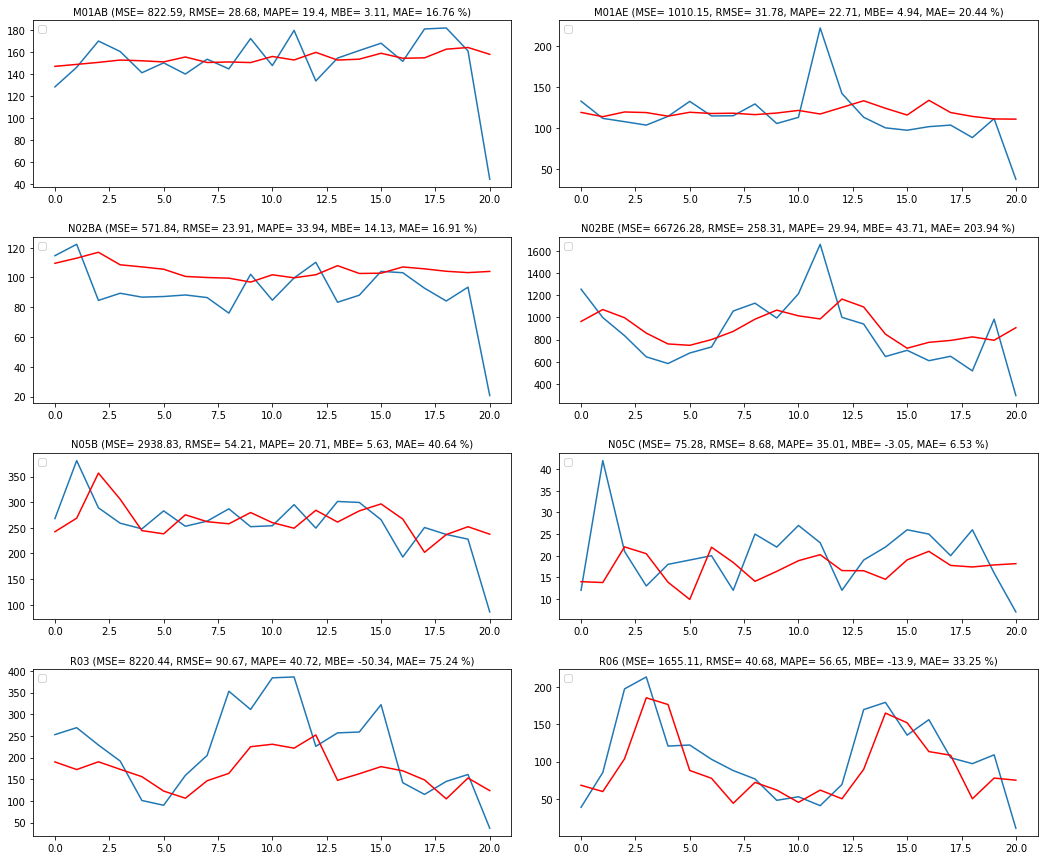

In [ ]:
subplotindex=0
fig, ax = plt.subplots(4, 2, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
warnings.filterwarnings("ignore")

for j in features:
  train, test = data2[0:int(len(data2)*0.7)], data2[int(len(data2)*0.7):]
  train = train[j].values
  test = test[j].values
  
  # train autoregression
  window = 5
  model = AutoReg(train, lags=5)
  model_fit = model.fit()
  coef = model_fit.params
  # walk forward over time steps in test
  history = train[len(train)-window:]
  history = [history[i] for i in range(len(history))]
  predictions = list()
  for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window , length)]
    yhat = coef[0]
    for d in range(window):
      yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
 
  # Validation
  # Mean Squarred Error (MSE) 
  MSE = np.round(mean_squared_error(test, predictions),2)
  mse.append(MSE)
  # Root Mean Squarred Error (RMSE) 
  RMSE = np.round(np.sqrt(MSE),2)
  rmse.append(RMSE)
  # Mean Absolute Percentage Error (MAPE)
  MAPE = np.round(mean_absolute_percentage_error(test, predictions)*100,2)
  mape.append(MAPE)
  # Mean Bias Error (MBE)
  MBE = np.round(np.mean(predictions - test),2)
  mbe.append(MBE)
  # Mean Absolute Error (MAE)
  MAE = np.round(mean_absolute_error(test, predictions),2)
  mae.append(MAE)

  #plot the data
  rowindex = math.floor(subplotindex/2)
  colindex = subplotindex-(rowindex*2)
  ax[rowindex,colindex].set_title("{0} (MSE= {1}, RMSE= {2}, MAPE= {3}, MBE= {4}, MAE= {5} %)".format(j ,MSE ,RMSE ,MAPE, MBE, MAE), fontsize = 10)
  ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
  ax[rowindex,colindex].plot(test)
  ax[rowindex,colindex].plot(predictions, color='red')
  subplotindex=subplotindex+1
plt.show()

In [ ]:
mse

[822.59, 1010.15, 571.84, 66726.28, 2938.83, 75.28, 8220.44, 1655.11]

In [ ]:
mape

[19.4, 22.71, 33.94, 29.94, 20.71, 35.01, 40.72, 56.65]

In [ ]:
rmse

[28.68, 31.78, 23.91, 258.31, 54.21, 8.68, 90.67, 40.68]

In [ ]:
mae

[16.76, 20.44, 16.91, 203.94, 40.64, 6.53, 75.24, 33.25]

In [ ]:
mbe

[3.11, 4.94, 14.13, 43.71, 5.63, -3.05, -50.34, -13.9]

# **XG Boost**

In [ ]:
#import the libraries
import math
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error , mean_absolute_percentage_error


In [ ]:
features = list(data1.columns)
del features[0]
del features[8:]
features

['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']

In [ ]:
mse = []
rmse = []
mape = []
mbe = []
mae = []

[18:54:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:54:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:54:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:54:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:54:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:54:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:54:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:54:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

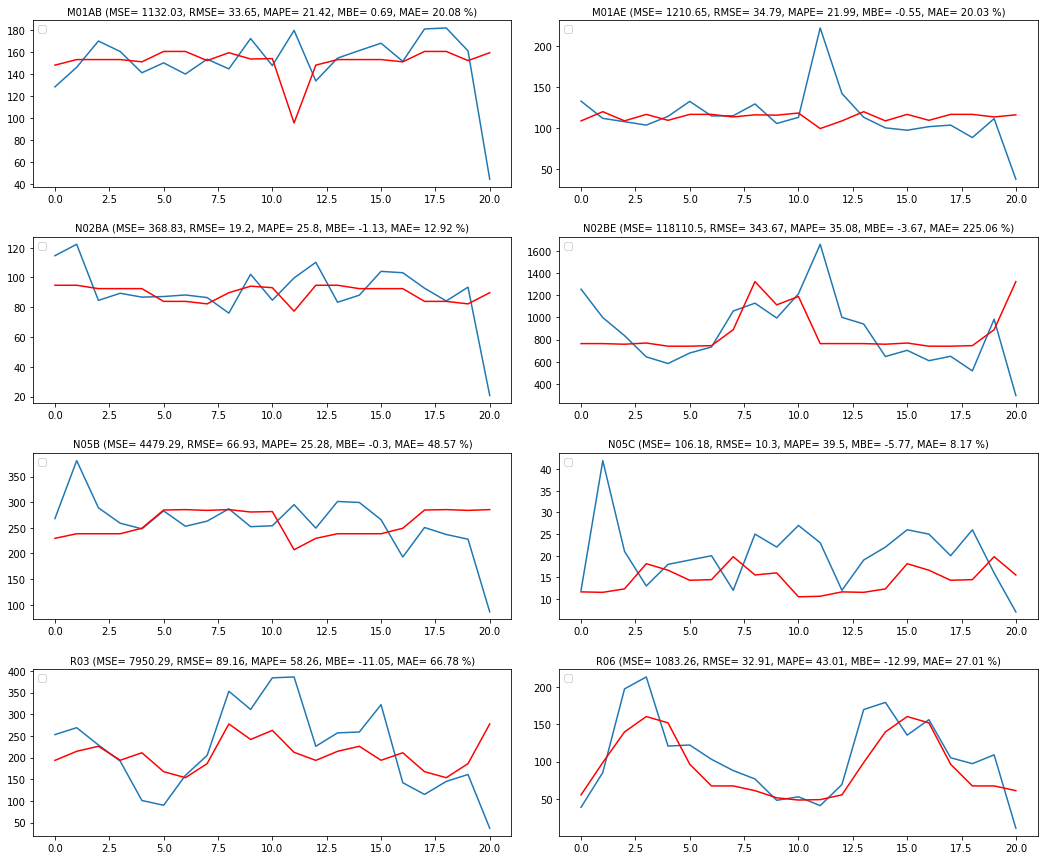

In [ ]:
subplotindex=0
fig, ax = plt.subplots(4, 2, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
warnings.filterwarnings("ignore")

for j in features:
  dataset = data1.filter([j,"year","month","day"])
  training_data = math.ceil(len(dataset) * 0.7)

  # #create the training data set
  # train_data = sc_data[0:training_data , :]

  #split
  X_train = dataset.iloc[0:training_data,1:]
  y_train = dataset.iloc[0:training_data,0]
  X_test = dataset.iloc[training_data:,1:]
  y_test = dataset.iloc[training_data:,0]
  
  reg = XGBRegressor(n_estimators=1000)
  reg.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=50, verbose=False)

  #get the models predicted price values
  predictions = reg.predict(X_test)
  
  # Validation
  # Mean Squarred Error (MSE) 
  MSE = np.round(mean_squared_error(y_test, predictions),2)
  mse.append(MSE)
  # Root Mean Squarred Error (RMSE) 
  RMSE = np.round(np.sqrt(MSE),2)
  rmse.append(RMSE)
  # Mean Absolute Percentage Error (MAPE)
  MAPE = np.round(mean_absolute_percentage_error(y_test, predictions)*100,2)
  mape.append(MAPE)
  # Mean Bias Error (MBE)
  MBE = np.round(np.mean(predictions-y_test),2)
  mbe.append(MBE)
  # Mean Absolute Error (MAE)
  MAE = np.round(mean_absolute_error(y_test, predictions),2)
  mae.append(MAE)

  #plot the data
  rowindex = math.floor(subplotindex/2)
  colindex = subplotindex-(rowindex*2)
  ax[rowindex,colindex].set_title("{0} (MSE= {1}, RMSE= {2}, MAPE= {3}, MBE= {4}, MAE= {5} %)".format(j ,MSE ,RMSE ,MAPE, MBE, MAE), fontsize = 10)
  ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
  ax[rowindex,colindex].plot(y_test.values)
  ax[rowindex,colindex].plot(predictions, color='red')
  subplotindex=subplotindex+1
plt.show()

# **LSTM**

In [ ]:
data2 = data1.set_index("datum")
data2.shape

(70, 8)

In [ ]:
features = list(data2.columns)
del features[8:]

In [ ]:
#import the libraries
import math
import warnings
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
mse = []
rmse = []
mape = []
mbe = []
mae = []

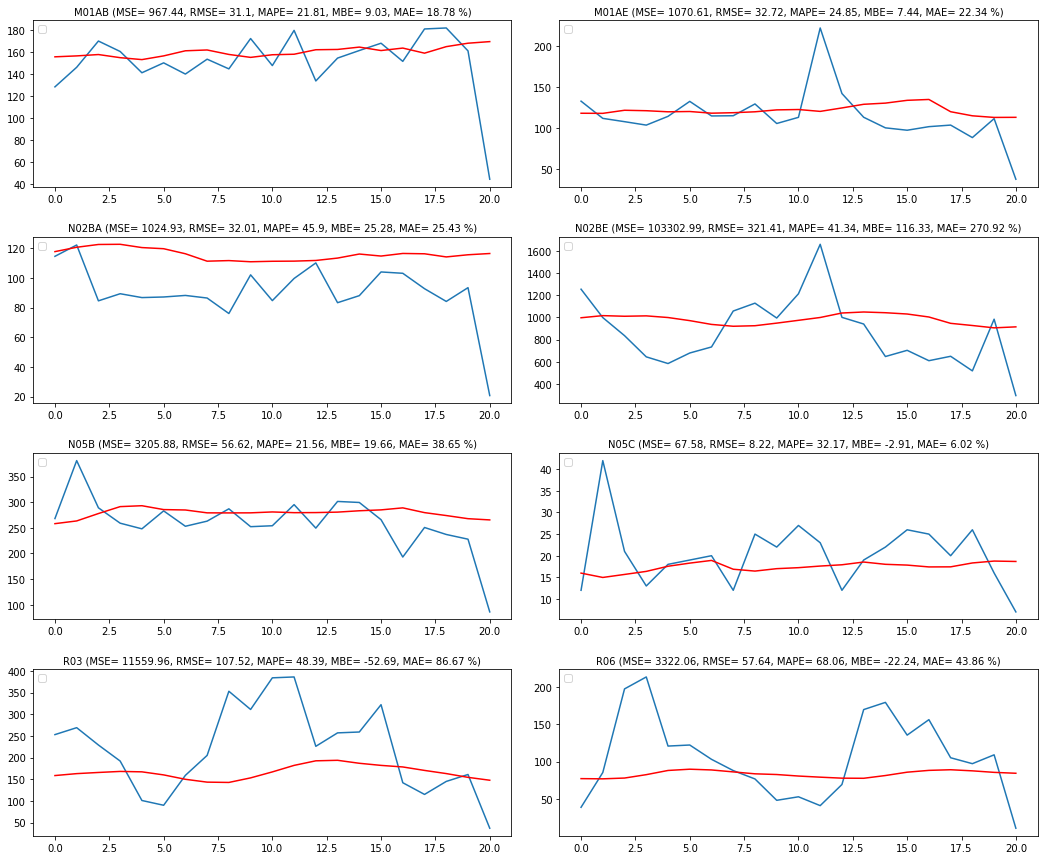

In [ ]:
subplotindex=0
fig, ax = plt.subplots(4, 2, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
warnings.filterwarnings("ignore")
n_steps = 5

for j in features:
  data3 = data2.filter([j])
  dataset = data3.values
  training_data = math.ceil(len(dataset) * 0.7)

  #Normalize the data
  sc = MinMaxScaler(feature_range=(0,1))
  sc_data = sc.fit_transform(dataset)

  #create the training data set
  train_data = sc_data[0:training_data , :]

  #split
  x_train = []
  y_train = []
  for i in range(n_steps, len(train_data)):
    x_train.append(train_data[i-n_steps:i ,0])
    y_train.append(train_data[i ,0])

  #convert the x_train and y_train
  x_train,y_train = np.array(x_train) , np.array(y_train)
  x_train=np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
  
  #create the testing dataset
  test_data = sc_data[training_data - n_steps: ,:]
  x_test = []
  y_test = dataset[training_data:, :]
  for i in range(n_steps , len(test_data)):
    x_test.append(test_data[i-n_steps:i,0])

  #convert the data to a numpy array
  x_test = np.array(x_test)
  x_test = np.reshape(x_test , (x_test.shape[0], x_test.shape[1], 1))

  #build the LSTM model
  model = Sequential()
  model.add(LSTM(100 ,activation='relu' ,return_sequences=True , input_shape=(x_train.shape[1],1)))
  model.add(Dropout(0.2))
  model.add(LSTM(100 ,activation='relu' , return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(25, activation='relu'))
  model.add(Dense(1))

  #compile the model
  model.compile(optimizer="adam",loss = "mean_squared_error")

  #Train the model
  history = model.fit(x_train , y_train, epochs=100, verbose=0, validation_split=0.3)

  #get the models predicted price values
  predictions = model.predict(x_test)
  predictions = sc.inverse_transform(predictions)
  
  # Validation
  # Mean Squarred Error (MSE) 
  MSE = np.round(mean_squared_error(y_test, predictions),2)
  mse.append(MSE)
  # Root Mean Squarred Error (RMSE) 
  RMSE = np.round(np.sqrt(MSE),2)
  rmse.append(RMSE)
  # Mean Absolute Percentage Error (MAPE)
  MAPE = np.round(mean_absolute_percentage_error(y_test, predictions)*100,2)
  mape.append(MAPE)
  # Mean Bias Error (MBE)
  MBE = np.round(np.mean(predictions-y_test),2)
  mbe.append(MBE)
  # Mean Absolute Error (MAE)
  MAE = np.round(mean_absolute_error(y_test, predictions),2)
  mae.append(MAE)

  #plot the data
  rowindex = math.floor(subplotindex/2)
  colindex = subplotindex-(rowindex*2)
  ax[rowindex,colindex].set_title("{0} (MSE= {1}, RMSE= {2}, MAPE= {3}, MBE= {4}, MAE= {5} %)".format(j ,MSE ,RMSE ,MAPE, MBE, MAE), fontsize = 10)
  ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
  ax[rowindex,colindex].plot(y_test)
  ax[rowindex,colindex].plot(predictions, color='red')
  subplotindex=subplotindex+1
plt.show()

# **CNN_LSTM**

In [ ]:
data2 = data1.set_index("datum")
data2.shape

(70, 8)

In [ ]:
features = list(data2.columns)
del features[8:]

In [ ]:
#import the libraries
import math
import warnings
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
mse = []
rmse = []
mape = []
mbe = []
mae = []

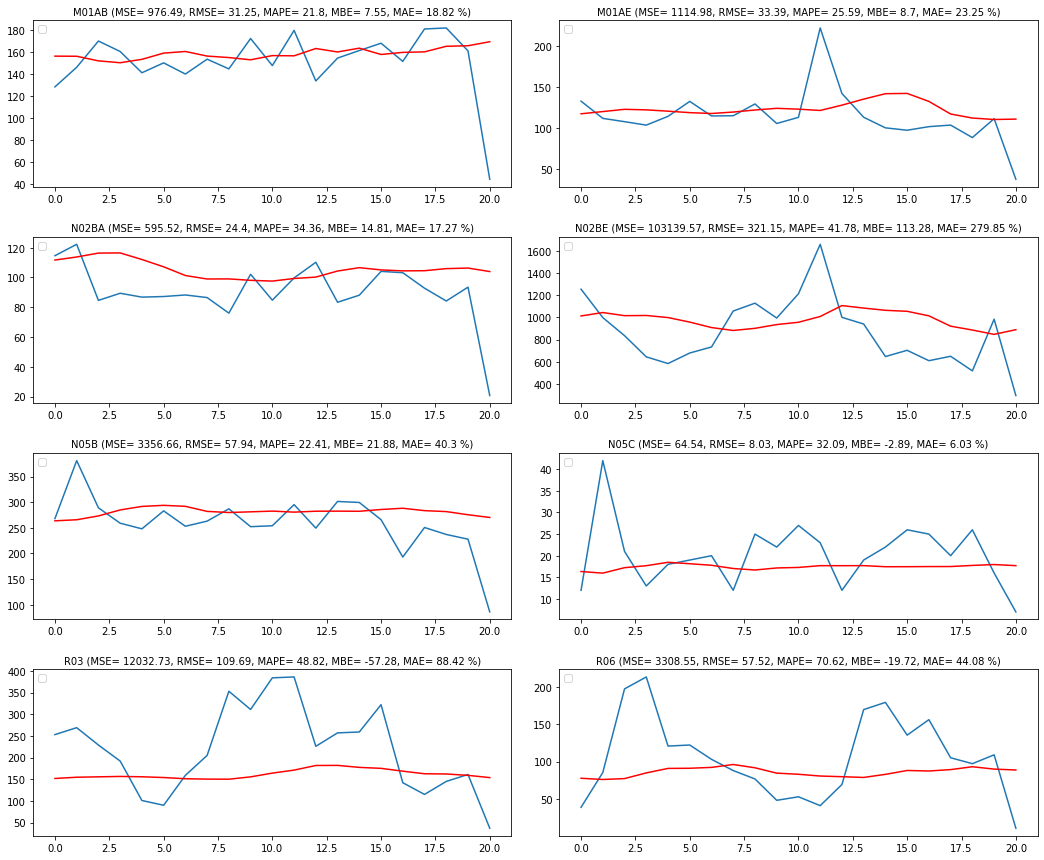

In [ ]:
subplotindex=0
fig, ax = plt.subplots(4, 2, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
warnings.filterwarnings("ignore")
n_steps = 5

for j in features:
  data3 = data2.filter([j])
  dataset = data3.values
  training_data = math.ceil(len(dataset) * 0.7)

  #Normalize the data
  sc = MinMaxScaler(feature_range=(0,1))
  sc_data = sc.fit_transform(dataset)

  #create the training data set
  train_data = sc_data[0:training_data , :]
  
  #split
  x_train = []
  y_train = []
  for i in range(n_steps, len(train_data)):
    x_train.append(train_data[i-n_steps:i ,0])
    y_train.append(train_data[i ,0])

  #convert the x_train and y_train
  x_train,y_train = np.array(x_train) , np.array(y_train)
  x_train=np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
  
  #create the testing dataset
  test_data = sc_data[training_data - n_steps: ,:]
  x_test = []
  y_test = dataset[training_data:, :]
  for i in range(n_steps , len(test_data)):
    x_test.append(test_data[i-n_steps:i,0])
    #y_test.append(test_data[i ,0])

  #convert the data to a numpy array
  x_test = np.array(x_test)
  x_test = np.reshape(x_test , (x_test.shape[0], x_test.shape[1], 1))

  #build the LSTM model
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1],x_train.shape[2])))
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=1))
  model.add(Flatten())
  model.add(RepeatVector(1))
  model.add(LSTM(100, activation='relu', return_sequences=True))
  model.add(TimeDistributed(Dense(100, activation='relu')))
  model.add(TimeDistributed(Dense(1)))


  #compile the model
  model.compile(optimizer="adam",loss = "mean_squared_error")

  #Train the model
  history = model.fit(x_train , y_train, epochs=100, verbose=0, validation_split=0.3)

  #get the models predicted price values
  #x_test = x_test.reshape((1, len(x_test), 1))
  predictions = model.predict(x_test)
  predictions = predictions.reshape((len(predictions), 1))
  predictions = sc.inverse_transform(predictions)
  
  # Validation
  # Mean Squarred Error (MSE) 
  MSE = np.round(mean_squared_error(y_test, predictions),2)
  mse.append(MSE)
  # Root Mean Squarred Error (RMSE) 
  RMSE = np.round(np.sqrt(MSE),2)
  rmse.append(RMSE)
  # Mean Absolute Percentage Error (MAPE)
  MAPE = np.round(mean_absolute_percentage_error(y_test, predictions)*100,2)
  mape.append(MAPE)
  # Mean Bias Error (MBE)
  MBE = np.round(np.mean(predictions-y_test),2)
  mbe.append(MBE)
  # Mean Absolute Error (MAE)
  MAE = np.round(mean_absolute_error(y_test, predictions),2)
  mae.append(MAE)

  #plot the data
  rowindex = math.floor(subplotindex/2)
  colindex = subplotindex-(rowindex*2)
  ax[rowindex,colindex].set_title("{0} (MSE= {1}, RMSE= {2}, MAPE= {3}, MBE= {4}, MAE= {5} %)".format(j ,MSE ,RMSE ,MAPE, MBE, MAE), fontsize = 10)
  ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
  ax[rowindex,colindex].plot(y_test)
  ax[rowindex,colindex].plot(predictions, color='red')
  subplotindex=subplotindex+1
plt.show()

# **ARIMA**

In [ ]:
data2 = data1.set_index("datum")
data2.shape

(70, 8)

In [ ]:
features = list(data2.columns)
del features[8:]

In [ ]:
#import the libraries
import math
import warnings
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
mse = []
rmse = []
mape = []
mbe = []
mae = []

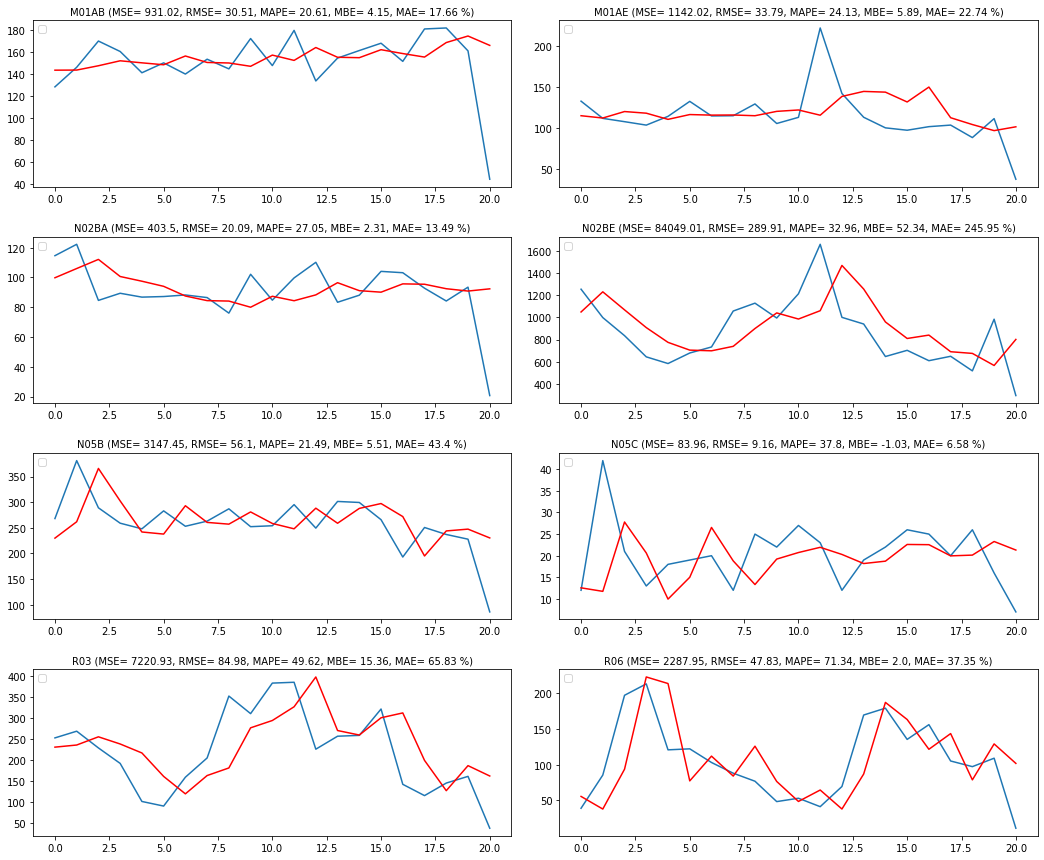

In [ ]:
subplotindex=0
fig, ax = plt.subplots(4, 2, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
warnings.filterwarnings("ignore")

for j in features:
  
  train_data, test_data = data2[0:int(len(data2)*0.7)], data2[int(len(data2)*0.7):]
  training_data = train_data[j].values
  test_data = test_data[j].values
  history = [x for x in training_data]
  model_predictions = []
  N_test_observations = len(test_data)
  for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
  MSE_error = mean_squared_error(test_data, model_predictions)
  
  # Validation
  # Mean Squarred Error (MSE) 
  MSE = np.round(mean_squared_error(test_data, model_predictions),2)
  mse.append(MSE)
  # Root Mean Squarred Error (RMSE) 
  RMSE = np.round(np.sqrt(MSE),2)
  rmse.append(RMSE)
  # Mean Absolute Percentage Error (MAPE)
  MAPE = np.round(mean_absolute_percentage_error(test_data, model_predictions)*100,2)
  mape.append(MAPE)
  # Mean Bias Error (MBE)
  MBE = np.round(np.mean(model_predictions - test_data),2)
  mbe.append(MBE)
  # Mean Absolute Error (MAE)
  MAE = np.round(mean_absolute_error(test_data, model_predictions),2)
  mae.append(MAE)

  #plot the data
  rowindex = math.floor(subplotindex/2)
  colindex = subplotindex-(rowindex*2)
  ax[rowindex,colindex].set_title("{0} (MSE= {1}, RMSE= {2}, MAPE= {3}, MBE= {4}, MAE= {5} %)".format(j ,MSE ,RMSE ,MAPE, MBE, MAE), fontsize = 10)
  ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
  ax[rowindex,colindex].plot(test_data)
  ax[rowindex,colindex].plot(model_predictions, color='red')
  subplotindex=subplotindex+1
plt.show()

In [ ]:
mse

[931.02, 1142.02, 403.5, 84049.01, 3147.45, 83.96, 7220.93, 2287.95]

In [ ]:
mape

[20.61, 24.13, 27.05, 32.96, 21.49, 37.8, 49.62, 71.34]

In [ ]:
rmse

[30.51, 33.79, 20.09, 289.91, 56.1, 9.16, 84.98, 47.83]

In [ ]:
mae

[17.66, 22.74, 13.49, 245.95, 43.4, 6.58, 65.83, 37.35]

In [ ]:
mbe

[4.15, 5.89, 2.31, 52.34, 5.51, -1.03, 15.36, 2.0]